In [1]:
#pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import os

In [3]:
dataTitle = 'Boreal_and_Arctic_food_webs_of_the_Barents_Sea.xlsx'
excel = pd.ExcelFile(dataTitle)
borealWeb = pd.read_excel(excel, 'The Boreal food web of the BS')
arcticWeb = pd.read_excel(excel, 'The Arctic food web of the BS')

In [4]:
borealTopRow = borealWeb.columns.tolist()
arcticTopRow = arcticWeb.columns.tolist()

borealSize = borealWeb.shape
arcticSize = arcticWeb.shape

In [5]:
with open("Boreal_Data.gml", "w") as gmlFile:
    gmlFile.write('graph\n')
    gmlFile.write('[\n')
    gmlFile.write('  directed 1\n')

    for i in range(borealSize[0]):
        gmlFile.write('  node\n  [\n')
        gmlFile.write('    id ' + str(i) + '\n')
        gmlFile.write('    label "' + str(borealWeb.iloc[i, 1]) + '"\n')
        gmlFile.write('  ]\n')

    for i in range(borealSize[0]):
        for j in range(borealSize[1]):
            if (borealWeb.iloc[i, j] == 1):
                gmlFile.write('  edge\n  [\n')
                gmlFile.write('    source ' + str(i) +'\n')
                gmlFile.write('    target ' + str(j - 2) + '\n')
                gmlFile.write('  ]\n')

    gmlFile.write(']')

In [6]:
with open("Arctic_Data.gml", "w") as gmlFile:
    gmlFile.write('graph\n')
    gmlFile.write('[\n')
    gmlFile.write('  directed 1\n')

    for i in range(arcticSize[0]):
        gmlFile.write('  node\n  [\n')
        gmlFile.write('    id ' + str(i) + '\n')
        gmlFile.write('    label "' + str(arcticWeb.iloc[i, 1]) + '"\n')
        gmlFile.write('  ]\n')

    for i in range(arcticSize[0]):
        for j in range(arcticSize[1]):
            if (arcticWeb.iloc[i, j] == 1):
                gmlFile.write('  edge\n  [\n')
                gmlFile.write('    source ' + str(i) +'\n')
                gmlFile.write('    target ' + str(j - 2) + '\n')
                gmlFile.write('  ]\n')

    gmlFile.write(']')

In [7]:
borealGraph = nx.read_gml('Boreal_Data.gml', label='id')
arcticGraph = nx.read_gml('Arctic_Data.gml', label='id')
borealLabels = nx.get_node_attributes(borealGraph, "label")
arcticLabels = nx.get_node_attributes(arcticGraph, "label")

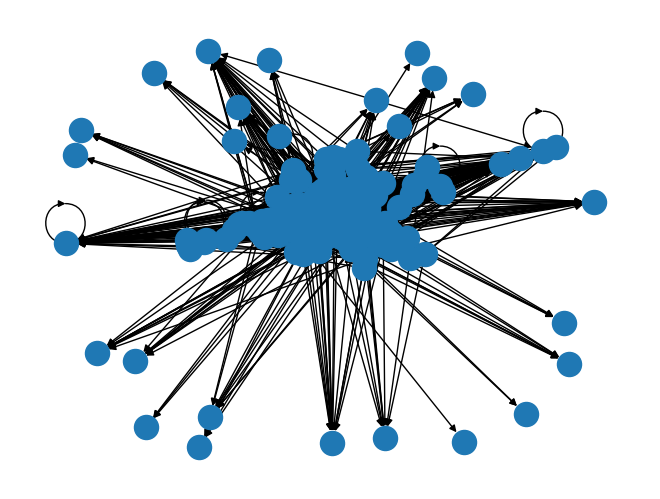

In [8]:
# nx.draw(borealGraph)

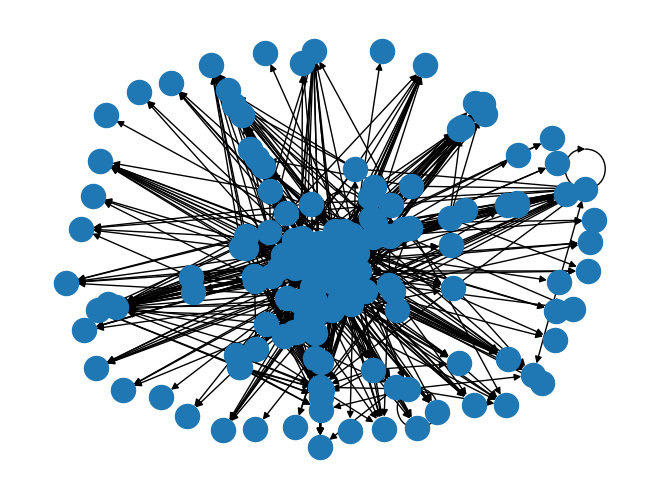

In [9]:
# nx.draw(arcticGraph)